# FasterRCNNN

## Imports

In [1]:
# imports
import torch
from torch import nn
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import platform
from torch.autograd import Variable
import time
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import GeneralizedRCNNTransform
from torchvision.models.detection import  FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import glob
import os
import json
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
# numba
import numba
from numba import jit

# vis
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn.metrics
from math import ceil
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import PIL

## Setup

In [2]:
# import dataset
train = pd.read_csv('../input/train_exploded_filled.csv')
id_s = pd.read_csv('../input/id_s.csv')

In [3]:
class Config:
    train_pcent = 0.8
    TRAIN_BS = 2
    VALID_BS = 2
    NB_EPOCHS = 10
    model_name = 'FasterRCNNDetector'
    reshape_size = (800, 800)
    num_classes = 4
    seed = 69
    iou_threshold = [0.5]
    mean = 0.532
    std = 0.208
    max_pixel_value = 1.0
    val_fold = 4
    save_path = 'C:\\Users\\Admin\\Git\\SIIM\\models\\FasterRCNNDetector\\'

In [4]:
config_dict = {attribute: value for attribute, value in Config.__dict__.items() if '__' not in attribute }

In [5]:
mapping = {0: 'Negative for Pneumonia',
1: 'Typical Appearance',
2: 'Indeterminate Appearance',
3: 'Atypical Appearance'}

In [6]:
Config.val_fold = 4
train_ids = id_s[id_s.fold!=4].id.values
valid_ids = id_s[id_s.fold==4].id.values

## Transformations

In [7]:

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5), 
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.4,
                                  contrast_limit=0.4, p=0.3),
        A.RandomGamma(gamma_limit=(50, 300), eps=None, always_apply=False, 
                      p=0.3),
        A.Resize(height=Config.reshape_size[0], width=Config.reshape_size[1], 
                 p=1.0),
        ToTensorV2(p=1.0)],
        bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

valid_transform = A.Compose([A.Resize(height=Config.reshape_size[0], 
                                      width=Config.reshape_size[1], p=1.0),
                             ToTensorV2(p=1.0)],
        bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Dataset

In [8]:
class SIIM(Dataset):
    def __init__(self, image_ids, df, transforms=None):
        super().__init__()
        # image_ids
        self.image_ids = image_ids
        # random sample data
        self.df = df
        # augmentations
        self.transforms = transforms
    
    def __len__(self) -> int:
        return(len(self.image_ids))
    
    @staticmethod
    def dicom2array(path: str, voi_lut=True, fix_monochrome=True):
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        return data.astype(np.float32)
    
    def load_bbox_labels(self, image_id, shape):
        row, col = shape
        records = self.df[self.df['id'] == image_id]
        boxes = []
        for bbox in records[['x', 'y', 'width', 'height']].values:
            # get xmin, ymin, xmax, ymax
            to_append = np.clip([bbox[0]/col, bbox[1]/row, (bbox[0]+bbox[2])/col, (bbox[1]+bbox[3])/row], 0, 1.0)
            temp = A.convert_bbox_from_albumentations(to_append, 'pascal_voc', rows=row, cols=col) 
            boxes.append(temp)
            #boxes.append(bbox)
        labels = records['integer_label'].values
        return(boxes, labels)
    
    def __getitem__(self, idx: int):
        # retrieve idx data
        image_id = self.image_ids[idx]
        # get path
        image_path = self.df[self.df['id'] == image_id].file_path.values[0]
        # get image
        image = self.dicom2array(image_path)
        # get boxes and labels
        boxes, labels = self.load_bbox_labels(image_id, image.shape)
        # target
        target = {
            'bboxes': boxes,
            'labels': torch.tensor(labels)
        }
        # Augments
        if self.transforms:
            t = self.transforms(**{'image': image,
                    'bboxes': target['bboxes'],
                    'labels': target['labels']})
            image = t['image']
            t_bboxes = torch.stack(tuple(map(torch.tensor, 
                                             zip(*t['bboxes'])))).permute(1, 0)
            target = {'boxes': t_bboxes,
                      'labels': torch.tensor(labels)}

        return image, target, image_id

### Showing Output of Dataset

In [9]:
# declare database
dataset = SIIM(image_ids=train_ids, df=train, transforms=train_transform)

In [10]:
def show_one(image, target):
    print(target)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    boxes = target['boxes'].numpy().astype(np.int32)
    image = image.squeeze(0).numpy()
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        startX, endX, startY, endY = int(xmin), int(xmax), int(ymin), int(ymax)
        color = (0, 255, 0)
        thickness = 1
        image = cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.bone)
    plt.show()

Showing image with id: 000c3a3f293f
{'boxes': tensor([[0.0000e+00, 7.9966e+02, 2.8249e-01, 8.0000e+02]], dtype=torch.float64), 'labels': tensor([0])}


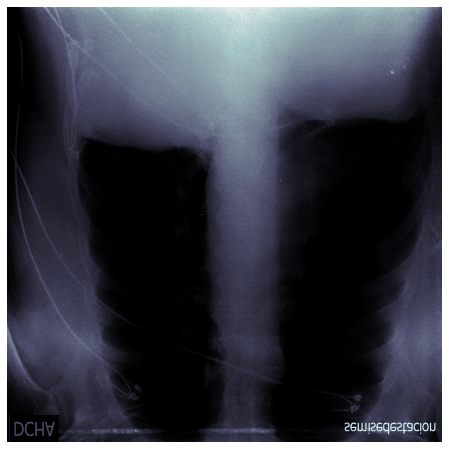

--------------------------------------------------
Showing image with id: 0022227f5adf
{'boxes': tensor([[214.2337, 160.1593, 312.8639, 286.0448]], dtype=torch.float64), 'labels': tensor([2])}


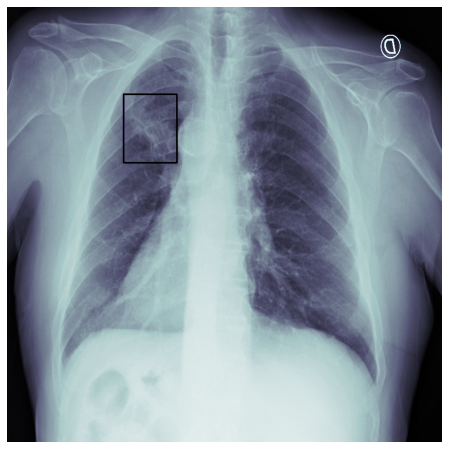

--------------------------------------------------
Showing image with id: 002e9b2128d0
{'boxes': tensor([[469.2708,  43.9587, 722.9167, 592.2418],
        [ 36.9791,  44.9254, 280.7292, 553.2362]], dtype=torch.float64), 'labels': tensor([1, 1])}


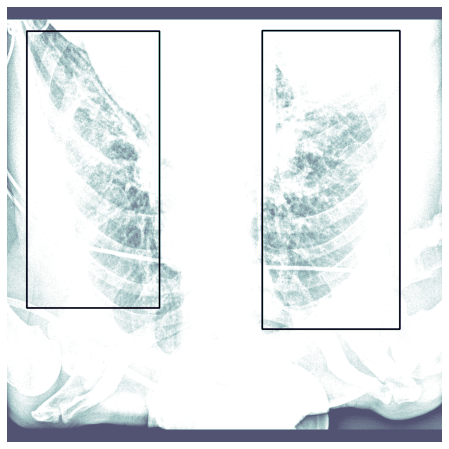

--------------------------------------------------
Showing image with id: 0044e449aae1
{'boxes': tensor([[ 62.3900, 321.3333, 319.3829, 609.3333],
        [486.3185, 337.3333, 670.8263, 502.6667]], dtype=torch.float64), 'labels': tensor([1, 1])}


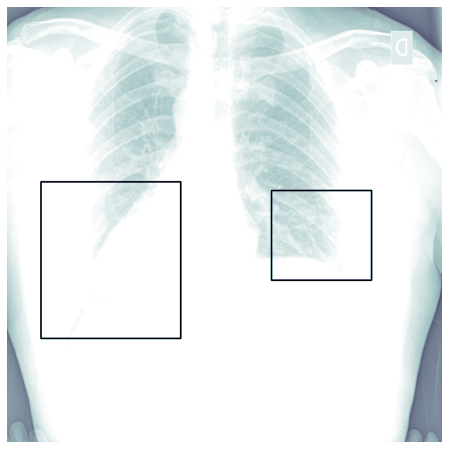

--------------------------------------------------
Showing image with id: 004cbd797cd1
{'boxes': tensor([[137.7502, 168.5716, 368.5895, 487.0440],
        [433.0322, 157.9879, 668.6807, 500.5141]], dtype=torch.float64), 'labels': tensor([1, 1])}


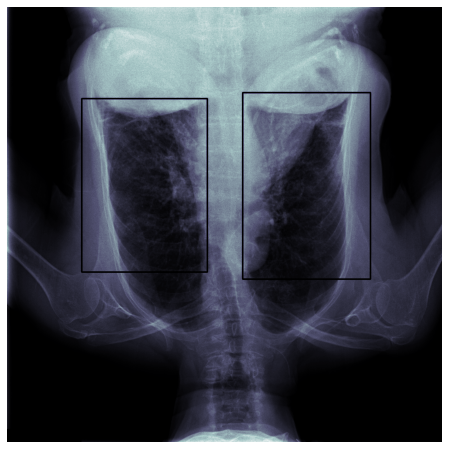

--------------------------------------------------
Showing image with id: 006e2ac85d57
{'boxes': tensor([[208.5540, 168.8120, 340.5295, 584.5447],
        [497.7597, 172.8679, 641.1405, 469.9647]], dtype=torch.float64), 'labels': tensor([1, 1])}


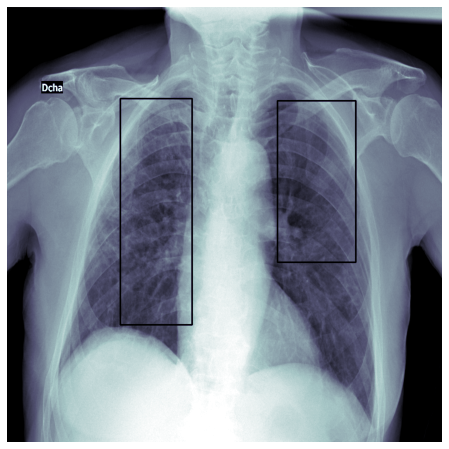

--------------------------------------------------
Showing image with id: 007cf31356c6
{'boxes': tensor([[ 20.3904, 145.3333, 207.2476, 418.6667],
        [441.0922, 138.6667, 678.2150, 336.0000]], dtype=torch.float64), 'labels': tensor([1, 1])}


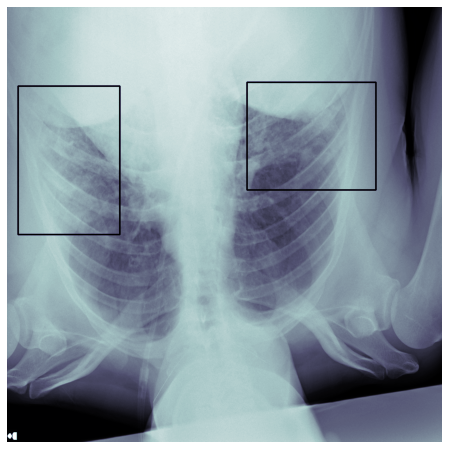

--------------------------------------------------
Showing image with id: 00a129830f4e
{'boxes': tensor([[485.8623, 169.5379, 660.0175, 397.3173]], dtype=torch.float64), 'labels': tensor([2])}


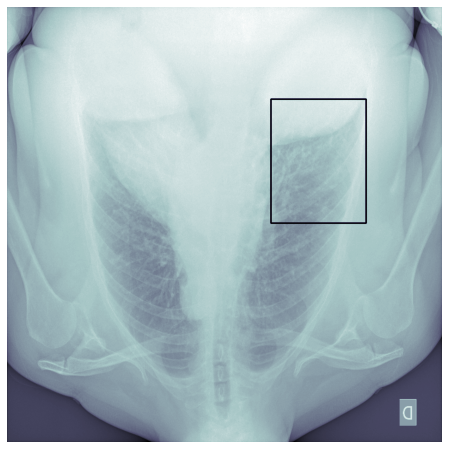

--------------------------------------------------
Showing image with id: 00b767b49fcd
{'boxes': tensor([[430.1328, 316.0000, 622.2527, 537.3333],
        [ 90.6481, 368.0000, 298.0503, 617.3333]], dtype=torch.float64), 'labels': tensor([1, 1])}


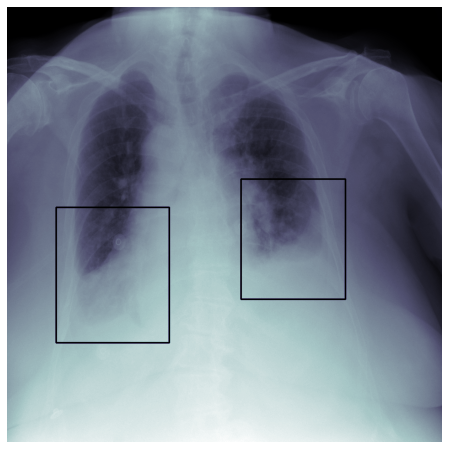

--------------------------------------------------
Showing image with id: cada5310214b
{'boxes': tensor([[103.5092, 262.9734, 233.7417, 620.2935],
        [474.2732, 321.1794, 613.1437, 658.2890]], dtype=torch.float64), 'labels': tensor([1, 1])}


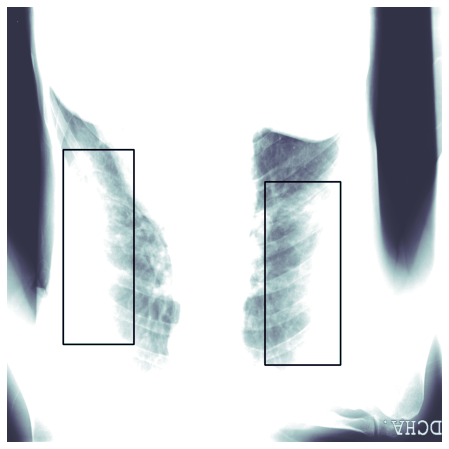

--------------------------------------------------


In [11]:
for i, (image, target, idx) in enumerate(dataset):
    if i % 2 ==0:
        continue
    if i > 20:
        break
    print(f'Showing image with id: {idx}')
    show_one(image, target)
    print('-'*50)

### Collate Function

In [12]:
def collate_fn(batch):
    images, targets, idx = tuple(zip(*batch))
    return(tuple((torch.stack(images).float(), targets, idx)))
    #return (tuple(zip(*batch))

## Model

In [13]:
import math
from torch import nn, Tensor
from typing import List, Tuple, Dict, Optional
from torchvision.models.detection.image_list import ImageList
from torchvision.models.detection.roi_heads import paste_masks_in_image

def resize_keypoints(keypoints, original_size, new_size):
    # type: (Tensor, List[int], List[int]) -> Tensor
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=keypoints.device) /
        torch.tensor(s_orig, dtype=torch.float32, device=keypoints.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_h, ratio_w = ratios
    resized_data = keypoints.clone()
    if torch._C._get_tracing_state():
        resized_data_0 = resized_data[:, :, 0] * ratio_w
        resized_data_1 = resized_data[:, :, 1] * ratio_h
        resized_data = torch.stack((resized_data_0, resized_data_1, resized_data[:, :, 2]), dim=2)
    else:
        resized_data[..., 0] *= ratio_w
        resized_data[..., 1] *= ratio_h
    return resized_data


def resize_boxes(boxes, original_size, new_size):
    # type: (Tensor, List[int], List[int]) -> Tensor
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device) /
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

class Identity2(nn.Module):
    def __init__(self, size_divisible=32):
        super(Identity2, self).__init__()
        self.size_divisible = size_divisible
        
    def forward(self,
                images,       # type: List[Tensor]
                targets=None  # type: Optional[List[Dict[str, Tensor]]]
                ):
        # type: (...) -> Tuple[ImageList, Optional[List[Dict[str, Tensor]]]]
        images = [img for img in images]
        if targets is not None:
            # make a copy of targets to avoid modifying it in-place
            # once torchscript supports dict comprehension
            # this can be simplified as follows
            # targets = [{k: v for k,v in t.items()} for t in targets]
            targets_copy: List[Dict[str, Tensor]] = []
            for t in targets:
                data: Dict[str, Tensor] = {}
                for k, v in t.items():
                    data[k] = v
                targets_copy.append(data)
            targets = targets_copy
        for i in range(len(images)):
            image = images[i]
            target_index = targets[i] if targets is not None else None

            if image.dim() != 3:
                raise ValueError("images is expected to be a list of 3d tensors "
                                 "of shape [C, H, W], got {}".format(image.shape))
            images[i] = image
            if targets is not None and target_index is not None:
                targets[i] = target_index

        image_sizes = [img.shape[-2:] for img in images]
        images = self.batch_images(images, size_divisible=self.size_divisible)
        image_sizes_list: List[Tuple[int, int]] = []
        for image_size in image_sizes:
            assert len(image_size) == 2
            image_sizes_list.append((image_size[0], image_size[1]))

        image_list = ImageList(images, image_sizes_list)
        return image_list, targets
    
    def batch_images(self, images, size_divisible=32):
        # type: (List[Tensor], int) -> Tensor
        if torchvision._is_tracing():
            # batch_images() does not export well to ONNX
            # call _onnx_batch_images() instead
            return self._onnx_batch_images(images, size_divisible)

        max_size = self.max_by_axis([list(img.shape) for img in images])
        stride = float(size_divisible)
        max_size = list(max_size)
        max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)
        max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)

        batch_shape = [len(images)] + max_size
        batched_imgs = images[0].new_full(batch_shape, 0)
        for img, pad_img in zip(images, batched_imgs):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

        return batched_imgs
    
    def max_by_axis(self, the_list):
        # type: (List[List[int]]) -> List[int]
        maxes = the_list[0]
        for sublist in the_list[1:]:
            for index, item in enumerate(sublist):
                maxes[index] = max(maxes[index], item)
        return maxes
    
    def postprocess(self,
                    result,               # type: List[Dict[str, Tensor]]
                    image_shapes,         # type: List[Tuple[int, int]]
                    original_image_sizes  # type: List[Tuple[int, int]]
                    ):
        # type: (...) -> List[Dict[str, Tensor]]
        if self.training:
            return result
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)
            result[i]["boxes"] = boxes
            if "masks" in pred:
                masks = pred["masks"]
                masks = paste_masks_in_image(masks, boxes, o_im_s)
                result[i]["masks"] = masks
            if "keypoints" in pred:
                keypoints = pred["keypoints"]
                keypoints = resize_keypoints(keypoints, im_s, o_im_s)
                result[i]["keypoints"] = keypoints
        return result

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        _indent = '\n    '
        format_string += "Custom version of GeneralizedRCNNTransform without resizing or norms..."
        format_string += '\n)'
        return format_string

In [14]:
class FasterRCNNDetector(torch.nn.Module):
    def __init__(self, pretrained=False, **kwargs):
        super(FasterRCNNDetector, self).__init__()
        # load pre-trained model incl. head
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained, 
                                                                          pretrained_backbone=pretrained)
        # change to 1 channel input
        self.model.backbone.body.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), 
                                                   stride=(2, 2), padding=(3, 3), 
                                                   bias=False)
        # self.model.backbone
        self.model.transform = Identity2()
        # get number of input features for the classifier custom head
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, Config.num_classes)
        
    def forward(self, images, targets=None):
        return self.model(images, targets)

## Image Precision

In [15]:
'''
https://www.kaggle.com/pestipeti/competition-metric-details-script
'''

@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.
       The mean average precision at different intersection over union (IoU) thresholds.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

# Logging

In [16]:
class logman(object):
    """
    Json data should save as follows:
    
    {'type': hyper, 'model':?, 'optim': ?, 'model': ?, 'train_len': ?, 'val_len': ?, 'device': ? ...etc...}

    {'type': train, 'epoch': num, 'batch': num, 'loss': num, ...etc...}

    {'type': val, 'epoch': num, 'batch': num, 'loss': num, 'metric': num ...etc...}

    {'type': final, 'epochs': num, 'batches': num, 'final_loss': num, 'final_metric': num ...etc...}
    
    """
    def __init__(self, hyper, save_path='./', save_name='logs'):
        #load
        self.hyper = hyper
        self.save_path = save_path
        self.save_name = save_name
        # assertions
        assert self.hyper['type'] == 'hyper'
        assert self.hyper['model']
        # init store
        self.store = {'model': self.hyper['model']}
        self.store.update({k: v for k, v in self.hyper.items() if (k != 'type' and k != 'model')})
        self.store['data'] = []
        # save empty logs
        self.save_logs()
        
    def save_logs(self):
        """
        The current implementation does not append or concatenate current file
        but instead save on top of current file with large dictionary.
        """
        with open(os.path.join(self.save_path, self.save_name)+'.json','w') as file:
            json.dump(self.store, file, indent = 4)
            file.close()
            
    def log(self, data):
        """
        Takes in any input data of form dict.
        Handles data by key 'type'.
        Sends to relevant method.
        """
        if data:
            # first log
            if not self.store['data']:
                self.store['data'] = [data]
            else:
                # check for final
                if data['type'] == 'final':
                    self.finalise(data)
                else:
                    # append data to data key in store
                    self.store['data'].append(data)
        else:
            # error
            self.store['data'].append({'type': 'error', 'reason': 'No data present'})
    
    def finalise(self, data):
        """
        Finalise logs, send final parameters to dict.
        Save logs
        """
        self.store.update({k: v for k, v in data.items() if (k != 'type' and k != 'model')})
        self.save_logs()
    

## Trainer

In [17]:
class Trainer:
    def __init__(self, train_dataloader, valid_dataloader, model,
                optimiser, logger=None, device='cpu'):
        """
        Constructor for Trainer class
        """
        self.train = train_dataloader
        self.valid = valid_dataloader
        self.model = model
        self.optim = optimiser
        self.logger = logger
        self.device = device
        
    def train_one_cycle(self, epoch):
        """
        Run one epoch of training, backpropogation and optimisation.
        """        
        # model train mode
        model.train()
        
        # progress bar
        train_prog_bar = tqdm(self.train, total=len(self.train))
        
        # stats
        all_train_labels = []
        all_train_preds = []
        running_loss = 0
        
        with torch.set_grad_enabled(True):
            for batch_num, (images, targets, idx) in enumerate(train_prog_bar):
                # zero gradient optim
                self.optim.zero_grad()
                
                # send to devices
                images = images.to(self.device)
                tg = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                # get outputs
                losses = model(images, tg)
                # training
                train_loss = sum(loss for loss in losses.values())

                # Backpropogation
                train_loss.backward()
                self.optim.step()
                
                # For averaging and reporting later
                running_loss += train_loss.item()
                
                # logging
                if self.logger:
                    self.logger.log({'type': 'train', 
                                     'epoch': epoch, 
                                     'batch': batch_num, 
                                     'loss': train_loss.item()
                                    })
                    
                # show the current loss to the progress bar
                train_pbar_desc = f'loss: {train_loss.item():.4f}'
                train_prog_bar.set_description(desc=train_pbar_desc)
                
            # average the running loss over all batches and return
            train_running_loss = running_loss / len(self.train)
            print(f"Final Training Loss: {train_running_loss:.4f}")

            # free memory
            del images, tg, losses, train_loss
            # free up cache
            torch.cuda.empty_cache()
            return(train_running_loss)
        

    def valid_one_cycle(self, epoch):
        """
        Runs one epoch of prediction.
        In model.train() mode, model(images)  is returning losses.
        We are using model.eval() mode --> it will return boxes and scores. 
        """        
        model.eval()
        
        valid_prog_bar = tqdm(self.valid, total=len(self.valid))
        count = 0
        i_sum = 0
        avg = 0
        with torch.no_grad():

            metric = 0

            for batch_num, (images, targets, idx) in enumerate(valid_prog_bar):
                # send to devices
                images = images.to(self.device)
                
                # get predictions
                outputs = model(images)
                
                # get metric
                for i, image in enumerate(images):               
                    gt_boxes = targets[i]['boxes'].data.cpu().numpy()
                    boxes = outputs[i]['boxes'].data.cpu().numpy()
                    scores = outputs[i]['scores'].detach().cpu().numpy()
                    
                    preds_sorted_idx = np.argsort(scores)[::-1]
                    preds_sorted_boxes = boxes[preds_sorted_idx]
                    precision = calculate_image_precision(preds_sorted_boxes,
                                                          gt_boxes,
                                                          thresholds=Config.iou_threshold,
                                                          form='pascal_voc')
                    count += 1
                    i_sum += precision * 1 # should be n but updating one at a time?
                    avg = i_sum / count
                    
                    # logging
                    if self.logger:
                        self.logger.log({'type': 'val', 
                                         'epoch': epoch, 
                                         'batch': batch_num, 
                                         'image_precision': precision,
                                         'average_precision': avg
                                        })
                        
                    # Show the current metric
                    valid_pbar_desc = f"Avg Precision: {avg:.4f}"
                    valid_prog_bar.set_description(desc=valid_pbar_desc)
            
            print(f"Validation metric: {avg:.4f}")

            # Free up memory
            del images, outputs, gt_boxes, boxes, scores, preds_sorted_idx, preds_sorted_boxes, precision
            torch.cuda.empty_cache()

            return (avg, model)

## Cycle

In [ ]:
# Training Cycle
nb_training_samples = len(train_ids)
nb_valid_samples = len(valid_ids)
print(f"[INFO] Training on {len(train_ids)} samples ({int(Config.train_pcent*100)}%) and validation on {nb_valid_samples} ({ceil(abs(1 - Config.train_pcent) * 100)}%) samples")

if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device('cuda:0')
else:
    print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
    DEVICE = torch.device('cpu')
################################################################################################################################        

# Make Training and Validation Datasets
training_set = SIIM(image_ids=train_ids, 
               df=train, transforms=train_transform)

validation_set = SIIM(image_ids=valid_ids, 
               df=train, transforms=valid_transform)

train_loader = DataLoader(
    training_set,
    batch_size=Config.TRAIN_BS,
    shuffle=True, collate_fn=collate_fn)

valid_loader = DataLoader(
    validation_set,
    batch_size=Config.VALID_BS,
    shuffle=False, collate_fn=collate_fn)
################################################################################################################################        
if "FasterRCNNDetector" in Config.model_name in Config.model_name:        
    model = FasterRCNNDetector(pretrained=True).to(DEVICE)
    
else:
    raise RuntimeError("Must specify a valid model type to train.")

print(f"Training Model: {Config.model_name}")

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
optim_name = 'Adam'
################################################################################################################################        
params = {'type': 'hyper',
          'model': Config.model_name,
          'optim': optim_name,
          'train_samples': nb_training_samples, 
          'val_samples': nb_valid_samples, 
          'device': torch.cuda.get_device_name()}
params.update(config_dict)
hyper_params = params
logman = logman(hyper_params, Config.save_path, Config.model_name)
################################################################################################################################        

trainer = Trainer(
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    model=model,
    optimiser=optim,
    logger=logman,
    device=DEVICE
)
################################################################################################################################        

train_losses_eff = []
valid_prec = []

for epoch in range(Config.NB_EPOCHS):
    # Empty CUDA cache
    torch.cuda.empty_cache()
    print(f"{'-'*20} EPOCH: {epoch+1}/{Config.NB_EPOCHS} {'-'*20}")

    # Run one training epoch
    current_train_loss = trainer.train_one_cycle(epoch)
    train_losses_eff.append(current_train_loss)

    # Run one validation epoch
    current_precision, op_model = trainer.valid_one_cycle(epoch)
    valid_prec.append(current_precision)
    op_model.eval()
    torch.save({
        'model_state_dict': op_model.state_dict(), #'model_state_dict': self.model.model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': current_train_loss,
        'image_precision': current_precision,
        'epoch': epoch,
        
    }, Config.save_path+'epoch_{epoch}.pth'.format(epoch=epoch))

logman.log({'type': 'final', 
            'final_loss': current_train_loss, 
            'final_metric': current_precision})

[INFO] Training on 4874 samples (80%) and validation on 1218 (20%) samples
[INFO] Using GPU: GeForce GTX 970



  0%|                                                                                         | 0/2437 [00:00<?, ?it/s]

Training Model: FasterRCNNDetector
-------------------- EPOCH: 1/10 --------------------


loss: 0.6450:   0%|▏                                                                | 6/2437 [00:11<1:39:41,  2.46s/it]

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, figsize=(15, 10))
ax.plot(np.arange(0, len(train_losses_eff), 1), train_losses_eff, label='Train')
ax.plot(np.arange(0, len(valid_prec), 1), valid_prec, label='Valid')
ax.set_xlabel('# of epochs')
ax.legend()
ax.set_title('Loss and Precision over epochs')
plt.show()